We need to evaluate features we can try and improve and restore for photos, this includes - 
    - Blurriness
    - Blemishes
    - Colour Faded/Low Saturations, etc

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Sharpening Photos 

In [ ]:
photo = cv2.imread('sample-photos/old_photo_01.jpg')

k = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]],dtype=float)
k = k / k.sum()
sharp = cv2.filter2D(photo, -1, k)

cv2.imshow('Original Image', photo)
cv2.imshow('Sharp Photo', sharp)

key = cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

Increasing brightness if brightness is below a certain threshold

In [ ]:
grey = cv2.cvtColor(sharp, cv2.COLOR_BGR2GRAY)

brightness = np.mean(grey) #mean to get brightness
brightened = sharp

# if image has low brightness
if brightness < 100:
    gamma = 1.5
    brightened = np.power(sharp / 255.0, 1 / gamma)
    brightened = np.uint8(brightened * 255)

# showing all for testing purposes
cv2.imshow('Original Image', photo)
cv2.imshow('Sharp Photo', sharp)
cv2.imshow('Brightened Image', brightened)
key = cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

thresholding or masking


In [5]:
def show_image(title, img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 4))
    plt.title(title)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

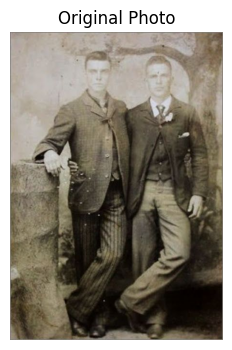

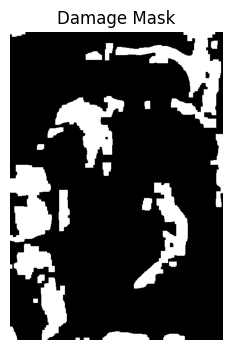

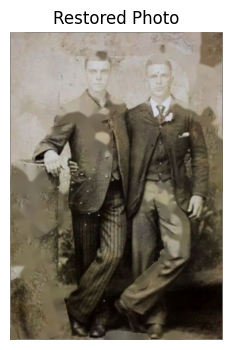

In [14]:
photo = cv2.imread('sample-photos/old_photo_16.jpg')
grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

mask_mid = cv2.inRange(grey, 110, 160) 
  
kernel = np.ones((5,5), np.uint8)
mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN, kernel)
mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_CLOSE, kernel)

mask_small = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN, np.ones((9,9), np.uint8))
_, damage_mask = cv2.threshold(mask_small, 127, 255, cv2.THRESH_BINARY)


restored = cv2.inpaint(photo, damage_mask, 5, cv2.INPAINT_TELEA)

show_image('Original Photo', photo)
show_image('Damage Mask', damage_mask)
show_image('Restored Photo', restored)


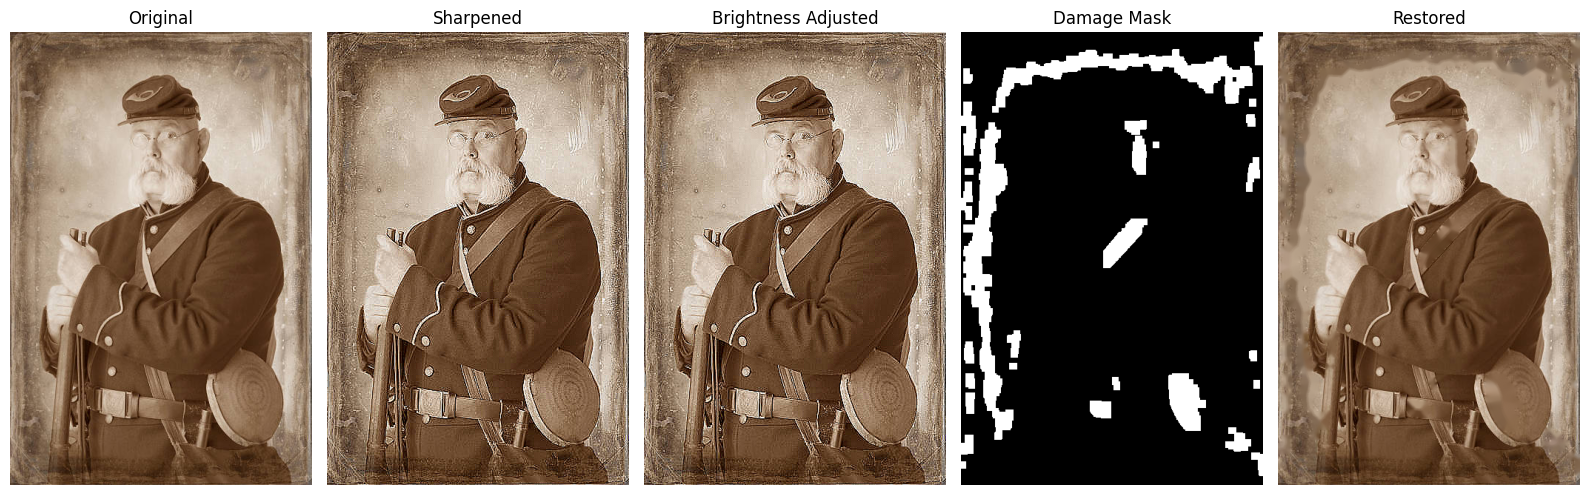

In [27]:
# libraries imported

import cv2
import numpy as np
import matplotlib.pyplot as plt

# functions for each processing step
def sharpen_image(photo):
    k = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]], dtype=float)
    k = k / k.sum()
    sharp = cv2.filter2D(photo, -1, k)
    return sharp


def adjust_brightness(photo, threshold=100, gamma=1.5):
    gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)

    if brightness < threshold:
        corrected = np.power(photo / 255.0, 1 / gamma)
        corrected = np.uint8(corrected * 255)
        return corrected
    
    return photo


def masking(photo):
    grey = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)   
    mask_mid = cv2.inRange(grey, 110, 160)

    kernel = np.ones((5,5), np.uint8)
    mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN, kernel)
    mask_mid = cv2.morphologyEx(mask_mid, cv2.MORPH_CLOSE, kernel)

    mask_small = cv2.morphologyEx(mask_mid, cv2.MORPH_OPEN, np.ones((9,9), np.uint8))
    hsv = cv2.cvtColor(photo, cv2.COLOR_BGR2HSV)
    _, _, v = cv2.split(hsv)

    _, damage_mask = cv2.threshold(mask_small, 127, 255, cv2.THRESH_BINARY)

    damage_mask = damage_mask.astype(np.uint8)       

    if damage_mask.shape != photo.shape[:2]:         
        damage_mask = cv2.resize(damage_mask, (photo.shape[1], photo.shape[0]))

    restored = cv2.inpaint(photo, damage_mask, 5, cv2.INPAINT_TELEA)

    return damage_mask, restored

def colour_correction(photo):
    photo_ycrcb = cv2.cvtColor(photo, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(photo_ycrcb)
    
    cr_corrected = cr - (np.mean(cr) - 128)
    cb_corrected = cb - (np.mean(cb) - 128)

    cr_corrected = np.clip(cr_corrected, 0, 255).astype(np.uint8)
    cb_corrected = np.clip(cb_corrected, 0, 255).astype(np.uint8)

    y_eq = cv2.equalizeHist(y)
    
    img_ycrcb_corrected = cv2.merge((y_eq, cr_corrected, cb_corrected))
    final_img = cv2.cvtColor(img_ycrcb_corrected, cv2.COLOR_YCrCb2BGR)

    return final_img

def denoise_image(photo):
    denoised_img = cv2.fastNlMeansDenoisingColored(photo, None, 5, 5, 7, 21)
    return denoised_img

def features_from_image(photo):
    gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 80, 160)

    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_mask = np.zeros_like(gray)
    for c in contours:
        if 20 < cv2.arcLength(c, True) < 300:
            cv2.drawContours(contour_mask, [c], -1, 255, -1)

    combined_mask = cv2.bitwise_or(edges, contour_mask)
    restored = cv2.inpaint(photo, combined_mask, 3, cv2.INPAINT_TELEA)

    return combined_mask, restored
    


def show_results(original, sharp, brightened, damage_mask, restored):
    plt.figure(figsize=(16, 5))

    titles = ["Original", "Sharpened", "Brightness Adjusted", "Damage Mask", "Restored"]
    images = [original, sharp, brightened, damage_mask, restored]

    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, 5, i)

        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



# main processing pipeline
photo = cv2.imread('sample-photos/old_photo_18.jpg')

sharp = sharpen_image(photo)
brightened = adjust_brightness(sharp)
damage_mask, restored = masking(photo)

show_results(photo, sharp, brightened, damage_mask, restored)